In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import datetime
from hatch import create_token_batches, TokenBatch, Commons
from convictionvoting import trigger_threshold
from policies import *
from network_utils import *
from IPython.core.debugger import set_trace
from entities import Participant, Proposal
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

In [2]:
# For the Flask backend

# Commons/Augmented Bonding Curve parameters
hatchers = 60
proposals = 3
hatch_tribute = 0.2
vesting_80p_unlocked = 60
exit_tribute = 0.35
# kappa = 2, default option set in abcurve.py, there is no way to reach it from here for now

# Conviction Voting parameters
days_to_80p_of_max_voting_weight = 10  # used in ProposalFunding.su_calculate_gathered_conviction
max_proposal_request = 0.2  # will be passed to trigger_threshold()

In [3]:
def update_collateral_pool(params, step, sL, s, _input):
    commons = s["commons"]
    s["collateral_pool"] = commons._collateral_pool
    return "collateral_pool", commons._collateral_pool


def update_token_supply(params, step, sL, s, _input):
    commons = s["commons"]
    s["token_supply"] = commons._token_supply
    return "token_supply", commons._token_supply


def update_funding_pool(params, step, sL, s, _input):
    commons = s["commons"]
    s["funding_pool"] = commons._funding_pool
    return "funding_pool", commons._funding_pool

In [4]:
contributions = [np.random.rand() * 10e5 for i in range(hatchers)]
token_batches, initial_token_supply = create_token_batches(contributions, 0.1, vesting_80p_unlocked)

commons = Commons(sum(contributions), initial_token_supply, hatch_tribute=0.2, exit_tribute=0.35)
network = bootstrap_network(token_batches, proposals, commons._funding_pool, commons._token_supply, max_proposal_request)

initial_conditions = {
    "network": network,
    "commons": commons,
    "funding_pool": commons._funding_pool,
    "collateral_pool": commons._collateral_pool,
    "token_supply": commons._token_supply,
    "sentiment": 0.5,
}

partial_state_update_blocks = [
    {
        "policies": {
            "generate_new_participants": GenerateNewParticipant.p_randomly,
        },
        'variables': {
            'network': GenerateNewParticipant.su_add_to_network,
            'commons': GenerateNewParticipant.su_add_investment_to_commons,
        }
    },
    {
        "policies": {},
        "variables": {
            "funding_pool": update_funding_pool,
            "collateral_pool": update_collateral_pool,
            "token_supply": update_token_supply,
        }
    },
    {
        "policies": {
            "generate_new_proposals": GenerateNewProposal.p_randomly,
        },
        "variables": {
            "network": GenerateNewProposal.su_add_to_network,
        }
    },
    {
        "policies": {
            "generate_new_funding": GenerateNewFunding.p_exit_tribute_of_average_speculator_position_size,
        },
        "variables": {
            "network": GenerateNewFunding.su_add_funding,
        }
    },
    {
        "policies": {},
        "variables": {
            "network": ProposalFunding.su_update_age_and_conviction_thresholds,
        }
    },
    {
        "policies": {
            "decide_which_proposals_should_be_funded": ProposalFunding.p_compare_conviction_and_threshold
        },
        "variables": {
            "network": ProposalFunding.su_compare_conviction_and_threshold_make_proposal_active,
            "commons": ProposalFunding.su_compare_conviction_and_threshold_deduct_funds_from_funding_pool,
        }
    },
        {
        "policies": {},
        "variables": {
            "funding_pool": update_funding_pool,
            "collateral_pool": update_collateral_pool,
            "token_supply": update_token_supply,
        }
    },
    {
        "policies": {
            "participants_stake_tokens_on_proposals": ParticipantVoting.p_participant_votes_on_proposal_according_to_affinity
        },
        "variables": {
            "network": ParticipantVoting.su_update_participants_votes,
        },
    },
    {
        "policies": {},
        "variables": {
            "network": ProposalFunding.su_calculate_conviction,
        }
    },
]

In [5]:

# TODO: make it explicit that 1 timestep is 1 day
simulation_parameters = {
    'T': range(150),
    'N': 1,
    'M': {
        # "sentiment_decay": 0.01, #termed mu in the state update function
        # "trigger_threshold": trigger_threshold,
        # "min_proposal_age_days": 7, # minimum periods passed before a proposal can pass,
        # "sentiment_sensitivity": 0.75,
        # 'min_supp':50, #number of tokens that must be stake for a proposal to be a candidate
        "debug": True,
        "days_to_80p_of_max_voting_weight": days_to_80p_of_max_voting_weight,
        "max_proposal_request": max_proposal_request,
    }
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc) # Do not use multi_proc, breaks ipdb.set_trace()
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f4b31ade550>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f4b31ade550>]
ProposalFunding: Proposal 60 has 0.0 conviction, and needs 146346907.52664086 to pass
ProposalFunding: Proposal 61 has 0.0 conviction, and needs 148800067.3481262 to pass
ProposalFunding: Proposal 62 has 0.0 conviction, and needs 159563135.19077292 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {60: 0.0014637331339197868, 61: 0.16858182507797725, 62: 0.5598373848701605} and he decided to vote on {62: 0.5598373848701605}, distributing his tokens thusly {62: 3588318.2045325707}
ParticipantVoting: Participant 2 

ProposalFunding: Proposal 60 has 84486414.1307185 conviction, and needs 146348729.06710494 to pass
ProposalFunding: Proposal 61 has 45030311.22557998 conviction, and needs 148801701.40064594 to pass
ProposalFunding: Proposal 62 has 77763680.26290148 conviction, and needs 159563883.7766753 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {60: 0.0014637331339197868, 61: 0.16858182507797725, 62: 0.5598373848701605} and he decided to vote on {62: 0.5598373848701605}, distributing his tokens thusly {62: 3588318.2045325707}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {60: 0.789433125128304, 61: 0.08639211549992254, 62: 0.10047464402211792} and he decided to vote on {60: 0.789433125128304}, distributing his tokens thusly {60: 967185.4913059851}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {60: 0.01704585033623951, 61: 0.9054233157744775, 62: 0.19914420784219444} and he decide

ProposalFunding: Proposal 60 has 929350555.4379036 conviction, and needs 146348370.12783444 to pass
ProposalFunding: Proposal 61 has 495333423.4813796 conviction, and needs 148801045.41671133 to pass
ProposalFunding: Proposal 62 has 855400482.8919163 conviction, and needs 159561840.61725864 to pass
ProposalFunding: Proposal 60 passed! deducting 11998.826151111512 from Commons funding pool
ProposalFunding: Proposal 61 passed! deducting 21388.642079869456 from Commons funding pool
ProposalFunding: Proposal 62 passed! deducting 59993.60312436721 from Commons funding pool
GenerateNewProposal: Participant 2 created Proposal 65
ProposalFunding: Proposal 65 has 0.0 conviction, and needs 198220164.09171215 to pass
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {65: 1} and he decided to vote on {65: 1}, distributing his tokens thusly {65: 967185.4913059851}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {65: 0.7397087632653

ProposalFunding: Proposal 65 has 792703542.1086569 conviction, and needs 198203475.8626507 to pass
ProposalFunding: Proposal 65 passed! deducting 168914.8223741938 from Commons funding pool
GenerateNewProposal: Participant 14 created Proposal 66
ProposalFunding: Proposal 66 has 0.0 conviction, and needs 388323476.18397015 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {66: 0.780370046625086} and he decided to vote on {66: 0.780370046625086}, distributing his tokens thusly {66: 3588318.2045325707}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {66: 0.5446940173627861} and he decided to vote on {66: 0.5446940173627861}, distributing his tokens thusly {66: 967185.4913059851}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {66: 0.6055735676218506} and he decided to vote on {66: 0.6055735676218506}, distributing his tokens thusly {66: 6258591.356375802}
ParticipantVoting: Parti

GenerateNewProposal: Participant 54 created Proposal 68
ProposalFunding: Proposal 68 has 0.0 conviction, and needs 198850088.81860122 to pass
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {68: 0.900168452081487} and he decided to vote on {68: 0.900168452081487}, distributing his tokens thusly {68: 6258591.356375802}
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {68: 0.9124331949225559} and he decided to vote on {68: 0.9124331949225559}, distributing his tokens thusly {68: 2002018.041283854}
ParticipantVoting: Participant 10 was given Proposals with corresponding affinities {68: 0.7502647013970463} and he decided to vote on {68: 0.7502647013970463}, distributing his tokens thusly {68: 9432076.229025437}
ParticipantVoting: Participant 16 was given Proposals with corresponding affinities {68: 0.7537453766226747} and he decided to vote on {68: 0.7537453766226747}, distributing his tokens thusly {68: 2968327.779601539

GenerateNewProposal: Participant 8 created Proposal 73
ProposalFunding: Proposal 73 has 0.0 conviction, and needs 194583421.60337806 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {73: 0.8358533803456902} and he decided to vote on {73: 0.8358533803456902}, distributing his tokens thusly {73: 6969752.267819494}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {73: 0.6439608365345124} and he decided to vote on {73: 0.6439608365345124}, distributing his tokens thusly {73: 6258591.356375802}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {73: 0.6716076857158855} and he decided to vote on {73: 0.6716076857158855}, distributing his tokens thusly {73: 1860372.6350835424}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {73: 0.7931265819558551} and he decided to vote on {73: 0.7931265819558551}, distributing his tokens thusly {73: 5213239.764955469

GenerateNewProposal: Participant 8 created Proposal 75
ProposalFunding: Proposal 75 has 0.0 conviction, and needs 182865273.37050793 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {75: 0.7181802406159254} and he decided to vote on {75: 0.7181802406159254}, distributing his tokens thusly {75: 6969752.267819494}
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {75: 0.8628780212232007} and he decided to vote on {75: 0.8628780212232007}, distributing his tokens thusly {75: 1733831.9119857203}
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {75: 1} and he decided to vote on {75: 1}, distributing his tokens thusly {75: 2002018.041283854}
ParticipantVoting: Participant 10 was given Proposals with corresponding affinities {75: 0.9956033161792676} and he decided to vote on {75: 0.9956033161792676}, distributing his tokens thusly {75: 9432076.229025437}
ParticipantVoting: Participant 

ProposalFunding: Proposal 75 has 842710529.7044291 conviction, and needs 182850855.33058086 to pass
ProposalFunding: Proposal 77 has 35362142.701800495 conviction, and needs 178346004.36337677 to pass
ProposalFunding: Proposal 78 has 0.0 conviction, and needs 197815837.96175474 to pass
ProposalFunding: Proposal 75 passed! deducting 106783.07053575123 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {77: 0.550425988555112, 78: 0.5492256717401182} and he decided to vote on {77: 0.550425988555112, 78: 0.5492256717401182}, distributing his tokens thusly {78: 3481072.242575122, 77: 3488680.025244372}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {77: 0.32085087634899956, 78: 0.6091472528063147} and he decided to vote on {78: 0.6091472528063147}, distributing his tokens thusly {78: 967185.4913059851}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {77: 0.1236145

ProposalFunding: Proposal 77 has 392495354.55570775 conviction, and needs 179311216.14701784 to pass
ProposalFunding: Proposal 78 has 100966682.77118912 conviction, and needs 199439207.13742137 to pass
ProposalFunding: Proposal 77 passed! deducting 96440.86315023527 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {78: 0.5492256717401182} and he decided to vote on {78: 0.5492256717401182}, distributing his tokens thusly {78: 6969752.267819494}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {78: 0.6091472528063147} and he decided to vote on {78: 0.6091472528063147}, distributing his tokens thusly {78: 967185.4913059851}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {78: 0.80429441354725} and he decided to vote on {78: 0.80429441354725}, distributing his tokens thusly {78: 6581485.990237713}
ParticipantVoting: Participant 7 was given Proposals with correspo

ProposalFunding: Proposal 83 has 87312922.50236365 conviction, and needs 162082854.19532156 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {83: 0.6445892139191927} and he decided to vote on {83: 0.6445892139191927}, distributing his tokens thusly {83: 6969752.267819494}
ParticipantVoting: Participant 9 was given Proposals with corresponding affinities {83: 0.9729616611696432} and he decided to vote on {83: 0.9729616611696432}, distributing his tokens thusly {83: 9229726.641339326}
ParticipantVoting: Participant 10 was given Proposals with corresponding affinities {83: 0.8898170649449615} and he decided to vote on {83: 0.8898170649449615}, distributing his tokens thusly {83: 9432076.229025437}
ParticipantVoting: Participant 21 was given Proposals with corresponding affinities {83: 0.8733961780926607} and he decided to vote on {83: 0.8733961780926607}, distributing his tokens thusly {83: 555864.436490091}
ParticipantVoting: Participant 24 was g

GenerateNewProposal: Participant 23 created Proposal 87
ProposalFunding: Proposal 85 has 113076616.97600976 conviction, and needs 241169997.30572218 to pass
ProposalFunding: Proposal 87 has 0.0 conviction, and needs 260080008.97064084 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {85: 0.16003435309464564, 87: 0.6499152505784317} and he decided to vote on {87: 0.6499152505784317}, distributing his tokens thusly {87: 6969752.267819494}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {85: 0.682010166345671, 87: 0.47809449516014735} and he decided to vote on {85: 0.682010166345671}, distributing his tokens thusly {85: 967185.4913059851}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {85: 0.8733914223682309, 87: 0.6053318978022948} and he decided to vote on {85: 0.8733914223682309}, distributing his tokens thusly {85: 6258591.356375802}
ParticipantVoting: Participant 5 was giv

ProposalFunding: Proposal 85 has 1227513076.0820668 conviction, and needs 241142791.0005666 to pass
ProposalFunding: Proposal 87 has 93609357.59204553 conviction, and needs 260045724.42011902 to pass
ProposalFunding: Proposal 85 passed! deducting 195922.89978226973 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {87: 0.6499152505784317} and he decided to vote on {87: 0.6499152505784317}, distributing his tokens thusly {87: 6969752.267819494}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {87: 0.6053318978022948} and he decided to vote on {87: 0.6053318978022948}, distributing his tokens thusly {87: 6258591.356375802}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {87: 0.5835093988921367} and he decided to vote on {87: 0.5835093988921367}, distributing his tokens thusly {87: 1860372.6350835424}
ParticipantVoting: Participant 7 was given Proposals with corr

ProposalFunding: Proposal 92 has 61149529.04762983 conviction, and needs 173952565.31383353 to pass
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {92: 0.8016755669436202} and he decided to vote on {92: 0.8016755669436202}, distributing his tokens thusly {92: 1860372.6350835424}
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {92: 0.5474749871947899} and he decided to vote on {92: 0.5474749871947899}, distributing his tokens thusly {92: 1733831.9119857203}
ParticipantVoting: Participant 12 was given Proposals with corresponding affinities {92: 0.5926684312503026} and he decided to vote on {92: 0.5926684312503026}, distributing his tokens thusly {92: 154271.8427385281}
ParticipantVoting: Participant 19 was given Proposals with corresponding affinities {92: 0.7765576880711603} and he decided to vote on {92: 0.7765576880711603}, distributing his tokens thusly {92: 581190.9812302806}
ParticipantVoting: Participant 23 wa

ProposalFunding: Proposal 94 has 86193503.1932752 conviction, and needs 355989820.3814855 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {94: 0.5350437499625174} and he decided to vote on {94: 0.5350437499625174}, distributing his tokens thusly {94: 3588318.2045325707}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {94: 0.5935049196900235} and he decided to vote on {94: 0.5935049196900235}, distributing his tokens thusly {94: 1860372.6350835424}
ParticipantVoting: Participant 15 was given Proposals with corresponding affinities {94: 0.725066685833384} and he decided to vote on {94: 0.725066685833384}, distributing his tokens thusly {94: 4223730.932004027}
ParticipantVoting: Participant 17 was given Proposals with corresponding affinities {94: 0.7590348649683452} and he decided to vote on {94: 0.7590348649683452}, distributing his tokens thusly {94: 8702045.92518293}
ParticipantVoting: Participant 19 was giv

ProposalFunding: Proposal 95 has 83992067.0751644 conviction, and needs 342133456.29959434 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {95: 0.9000276035459378} and he decided to vote on {95: 0.9000276035459378}, distributing his tokens thusly {95: 6969752.267819494}
ParticipantVoting: Participant 10 was given Proposals with corresponding affinities {95: 0.6570255863981806} and he decided to vote on {95: 0.6570255863981806}, distributing his tokens thusly {95: 9432076.229025437}
ParticipantVoting: Participant 14 was given Proposals with corresponding affinities {95: 0.7406575663838866} and he decided to vote on {95: 0.7406575663838866}, distributing his tokens thusly {95: 3212440.4410242545}
ParticipantVoting: Participant 16 was given Proposals with corresponding affinities {95: 0.589570195375416} and he decided to vote on {95: 0.589570195375416}, distributing his tokens thusly {95: 2968327.7796015395}
ParticipantVoting: Participant 17 was 

GenerateNewProposal: Participant 40 created Proposal 98
ProposalFunding: Proposal 97 has 98558776.66778404 conviction, and needs 164745132.4875164 to pass
ProposalFunding: Proposal 98 has 0.0 conviction, and needs 244966302.10801357 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {97: 0.5134626986520748, 98: 0.5740920434833914} and he decided to vote on {97: 0.5134626986520748, 98: 0.5740920434833914}, distributing his tokens thusly {97: 1694137.7546696065, 98: 1894180.449862964}
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {97: 0.9901555900798347, 98: 0.04923039958544184} and he decided to vote on {97: 0.9901555900798347}, distributing his tokens thusly {97: 6969752.267819494}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {97: 0.18247737165305666, 98: 0.9093231079400775} and he decided to vote on {98: 0.9093231079400775}, distributing his tokens thusly {98: 967185.4913

ProposalFunding: Proposal 97 has 1078928975.4218578 conviction, and needs 164736578.87414432 to pass
ProposalFunding: Proposal 98 has 80694816.2811866 conviction, and needs 244912143.77671742 to pass
ProposalFunding: Proposal 97 passed! deducting 44074.729893142496 from Commons funding pool
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {98: 0.5740920434833914} and he decided to vote on {98: 0.5740920434833914}, distributing his tokens thusly {98: 3588318.2045325707}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {98: 0.9093231079400775} and he decided to vote on {98: 0.9093231079400775}, distributing his tokens thusly {98: 967185.4913059851}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {98: 0.593681396921367} and he decided to vote on {98: 0.593681396921367}, distributing his tokens thusly {98: 5213239.764955469}
ParticipantVoting: Participant 7 was given Proposals with corres

ProposalFunding: Proposal 100 has 77838887.69551694 conviction, and needs 167928322.90885684 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {100: 0.909003087236237} and he decided to vote on {100: 0.909003087236237}, distributing his tokens thusly {100: 3588318.2045325707}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {100: 0.6433070668782167} and he decided to vote on {100: 0.6433070668782167}, distributing his tokens thusly {100: 6581485.990237713}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {100: 0.6988484160126345} and he decided to vote on {100: 0.6988484160126345}, distributing his tokens thusly {100: 6258591.356375802}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {100: 0.5349370450321801} and he decided to vote on {100: 0.5349370450321801}, distributing his tokens thusly {100: 5213239.764955469}
ParticipantVoting: Participa

ProposalFunding: Proposal 102 has 119437945.36378148 conviction, and needs 290511526.765107 to pass
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {102: 0.7639592881802161} and he decided to vote on {102: 0.7639592881802161}, distributing his tokens thusly {102: 5213239.764955469}
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {102: 0.8386120689712022} and he decided to vote on {102: 0.8386120689712022}, distributing his tokens thusly {102: 2002018.041283854}
ParticipantVoting: Participant 11 was given Proposals with corresponding affinities {102: 0.5390914301122496} and he decided to vote on {102: 0.5390914301122496}, distributing his tokens thusly {102: 1395615.5320257344}
ParticipantVoting: Participant 13 was given Proposals with corresponding affinities {102: 0.7703596878413033} and he decided to vote on {102: 0.7703596878413033}, distributing his tokens thusly {102: 2596249.2296708995}
ParticipantVoting: Parti

ProposalFunding: Proposal 103 has 105366937.533608 conviction, and needs 221765311.31069005 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {103: 0.6443783837246854} and he decided to vote on {103: 0.6443783837246854}, distributing his tokens thusly {103: 3588318.2045325707}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {103: 0.6620270143348609} and he decided to vote on {103: 0.6620270143348609}, distributing his tokens thusly {103: 5213239.764955469}
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {103: 0.6965953623612918} and he decided to vote on {103: 0.6965953623612918}, distributing his tokens thusly {103: 1733831.9119857203}
ParticipantVoting: Participant 9 was given Proposals with corresponding affinities {103: 0.7883229203990497} and he decided to vote on {103: 0.7883229203990497}, distributing his tokens thusly {103: 9229726.641339326}
ParticipantVoting: Partici

ProposalFunding: Proposal 104 has 101458081.60500264 conviction, and needs 269933967.00075054 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {104: 0.9257127099743823} and he decided to vote on {104: 0.9257127099743823}, distributing his tokens thusly {104: 3588318.2045325707}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {104: 0.8388218142959121} and he decided to vote on {104: 0.8388218142959121}, distributing his tokens thusly {104: 6581485.990237713}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {104: 0.5912270276278802} and he decided to vote on {104: 0.5912270276278802}, distributing his tokens thusly {104: 6258591.356375802}
ParticipantVoting: Participant 9 was given Proposals with corresponding affinities {104: 0.9854893621803325} and he decided to vote on {104: 0.9854893621803325}, distributing his tokens thusly {104: 9229726.641339326}
ParticipantVoting: Partic

GenerateNewProposal: Participant 46 created Proposal 107
ProposalFunding: Proposal 106 has 64756357.11691886 conviction, and needs 259653019.90580297 to pass
ProposalFunding: Proposal 107 has 0.0 conviction, and needs 144546585.15471372 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {106: 0.1285408838079708, 107: 0.6822268787103076} and he decided to vote on {107: 0.6822268787103076}, distributing his tokens thusly {107: 6969752.267819494}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {106: 0.021346505323816767, 107: 0.8986729103222948} and he decided to vote on {107: 0.8986729103222948}, distributing his tokens thusly {107: 1860372.6350835424}
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {106: 0.3421674687645756, 107: 0.8507427341734058} and he decided to vote on {107: 0.8507427341734058}, distributing his tokens thusly {107: 2002018.041283854}
ParticipantVoting: Part

ProposalFunding: Proposal 106 has 701065741.3500034 conviction, and needs 259618576.9806159 to pass
ProposalFunding: Proposal 107 has 42721361.7119514 conviction, and needs 144546346.35714123 to pass
ProposalFunding: Proposal 106 passed! deducting 133679.80518356047 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {107: 0.6822268787103076} and he decided to vote on {107: 0.6822268787103076}, distributing his tokens thusly {107: 6969752.267819494}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {107: 0.8986729103222948} and he decided to vote on {107: 0.8986729103222948}, distributing his tokens thusly {107: 1860372.6350835424}
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {107: 0.8507427341734058} and he decided to vote on {107: 0.8507427341734058}, distributing his tokens thusly {107: 2002018.041283854}
ParticipantVoting: Participant 11 was given Proposal

ProposalFunding: Proposal 109 has 106806284.73341188 conviction, and needs 432289362.7147322 to pass
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {109: 1} and he decided to vote on {109: 1}, distributing his tokens thusly {109: 6581485.990237713}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {109: 0.6740707561738868} and he decided to vote on {109: 0.6740707561738868}, distributing his tokens thusly {109: 1860372.6350835424}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {109: 0.6941730171123387} and he decided to vote on {109: 0.6941730171123387}, distributing his tokens thusly {109: 5213239.764955469}
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {109: 0.8666473203945154} and he decided to vote on {109: 0.8666473203945154}, distributing his tokens thusly {109: 1733831.9119857203}
ParticipantVoting: Participant 9 was given Proposals with c

GenerateNewProposal: Participant 18 created Proposal 112
ProposalFunding: Proposal 111 has 84247535.29407625 conviction, and needs 165442659.86707893 to pass
ProposalFunding: Proposal 112 has 0.0 conviction, and needs 182809979.7148041 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {111: 0.9014577439577082, 112: 0.8065830265379662} and he decided to vote on {111: 0.9014577439577082, 112: 0.8065830265379662}, distributing his tokens thusly {112: 3291305.4392526504, 111: 3678446.8285668436}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {111: 1, 112: 0.7398568926677096} and he decided to vote on {111: 1}, distributing his tokens thusly {111: 6258591.356375802}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {111: 0.0592555090597352, 112: 0.5605382078034646} and he decided to vote on {112: 0.5605382078034646}, distributing his tokens thusly {112: 1860372.6350835424}
Participa

GenerateNewProposal: Participant 55 created Proposal 113
ProposalFunding: Proposal 111 has 900410667.1535684 conviction, and needs 165433763.65965933 to pass
ProposalFunding: Proposal 112 has 74451628.3912571 conviction, and needs 182792889.7681082 to pass
ProposalFunding: Proposal 113 has 0.0 conviction, and needs 201536569.23997557 to pass
ProposalFunding: Proposal 111 passed! deducting 31393.782446403726 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {112: 0.8065830265379662, 113: 0.9294563117507629} and he decided to vote on {112: 0.8065830265379662, 113: 0.9294563117507629}, distributing his tokens thusly {112: 3238223.78583839, 113: 3731528.4819811042}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {112: 0.29820085488788917, 113: 0.7436516345935955} and he decided to vote on {113: 0.7436516345935955}, distributing his tokens thusly {113: 6581485.990237713}
ParticipantVoting: Particip

ProposalFunding: Proposal 112 has 839190895.7888999 conviction, and needs 183445697.2948077 to pass
ProposalFunding: Proposal 113 has 47291554.25221596 conviction, and needs 202571774.46270984 to pass
ProposalFunding: Proposal 112 passed! deducting 51923.48017304451 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {113: 0.9294563117507629} and he decided to vote on {113: 0.9294563117507629}, distributing his tokens thusly {113: 6969752.267819494}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {113: 0.7436516345935955} and he decided to vote on {113: 0.7436516345935955}, distributing his tokens thusly {113: 6581485.990237713}
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {113: 0.7104233878066508} and he decided to vote on {113: 0.7104233878066508}, distributing his tokens thusly {113: 1733831.9119857203}
ParticipantVoting: Participant 10 was given Proposal

ProposalFunding: Proposal 115 has 56239256.22508614 conviction, and needs 189198740.6211774 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {115: 0.7555750455088018} and he decided to vote on {115: 0.7555750455088018}, distributing his tokens thusly {115: 3588318.2045325707}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {115: 0.7560033865634448} and he decided to vote on {115: 0.7560033865634448}, distributing his tokens thusly {115: 967185.4913059851}
ParticipantVoting: Participant 14 was given Proposals with corresponding affinities {115: 0.5722657471578463} and he decided to vote on {115: 0.5722657471578463}, distributing his tokens thusly {115: 3212440.4410242545}
ParticipantVoting: Participant 18 was given Proposals with corresponding affinities {115: 0.6004384785950656} and he decided to vote on {115: 0.6004384785950656}, distributing his tokens thusly {115: 3086563.655810547}
ParticipantVoting: Parti

GenerateNewProposal: Participant 51 created Proposal 119
ProposalFunding: Proposal 117 has 131245487.95091689 conviction, and needs 208364230.0796921 to pass
ProposalFunding: Proposal 119 has 0.0 conviction, and needs 217259896.4619461 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {117: 0.20506962740362933, 119: 0.7877914582335107} and he decided to vote on {119: 0.7877914582335107}, distributing his tokens thusly {119: 3588318.2045325707}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {117: 0.7285654611522591, 119: 0.9945364224298732} and he decided to vote on {119: 0.9945364224298732}, distributing his tokens thusly {119: 967185.4913059851}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {117: 0.688991041659774, 119: 0.07074253404650899} and he decided to vote on {117: 0.688991041659774}, distributing his tokens thusly {117: 6581485.990237713}
ParticipantVoting: Partici

ProposalFunding: Proposal 117 has 1436773847.1242855 conviction, and needs 208336529.4294349 to pass
ProposalFunding: Proposal 119 has 40231664.35202116 conviction, and needs 217227438.6777659 to pass
ProposalFunding: Proposal 117 passed! deducting 70416.39242380414 from Commons funding pool
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {119: 0.7877914582335107} and he decided to vote on {119: 0.7877914582335107}, distributing his tokens thusly {119: 3588318.2045325707}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {119: 0.9945364224298732} and he decided to vote on {119: 0.9945364224298732}, distributing his tokens thusly {119: 967185.4913059851}
ParticipantVoting: Participant 9 was given Proposals with corresponding affinities {119: 0.8092475002521704} and he decided to vote on {119: 0.8092475002521704}, distributing his tokens thusly {119: 9229726.641339326}
ParticipantVoting: Participant 11 was given Proposal

ProposalFunding: Proposal 120 has 101515353.22616585 conviction, and needs 165615991.99348858 to pass
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {120: 0.7359498327845848} and he decided to vote on {120: 0.7359498327845848}, distributing his tokens thusly {120: 967185.4913059851}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {120: 0.5560316433988911} and he decided to vote on {120: 0.5560316433988911}, distributing his tokens thusly {120: 6581485.990237713}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {120: 0.6708823511394457} and he decided to vote on {120: 0.6708823511394457}, distributing his tokens thusly {120: 6258591.356375802}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {120: 0.5264101837093688} and he decided to vote on {120: 0.5264101837093688}, distributing his tokens thusly {120: 5213239.764955469}
ParticipantVoting: Partici

ProposalFunding: Proposal 121 has 51743177.990273304 conviction, and needs 167701424.55746853 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {121: 0.5264985877119737} and he decided to vote on {121: 0.5264985877119737}, distributing his tokens thusly {121: 6969752.267819494}
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {121: 0.6636270097165073} and he decided to vote on {121: 0.6636270097165073}, distributing his tokens thusly {121: 2002018.041283854}
ParticipantVoting: Participant 10 was given Proposals with corresponding affinities {121: 0.500570553487949} and he decided to vote on {121: 0.500570553487949}, distributing his tokens thusly {121: 9432076.229025437}
ParticipantVoting: Participant 16 was given Proposals with corresponding affinities {121: 0.7508952562366618} and he decided to vote on {121: 0.7508952562366618}, distributing his tokens thusly {121: 2968327.7796015395}
ParticipantVoting: Partic

ProposalFunding: Proposal 123 has 74513429.88477844 conviction, and needs 232910609.92253554 to pass
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {123: 0.5630269587956984} and he decided to vote on {123: 0.5630269587956984}, distributing his tokens thusly {123: 1733831.9119857203}
ParticipantVoting: Participant 10 was given Proposals with corresponding affinities {123: 0.5786974212037235} and he decided to vote on {123: 0.5786974212037235}, distributing his tokens thusly {123: 9432076.229025437}
ParticipantVoting: Participant 12 was given Proposals with corresponding affinities {123: 0.7979973785383695} and he decided to vote on {123: 0.7979973785383695}, distributing his tokens thusly {123: 154271.8427385281}
ParticipantVoting: Participant 22 was given Proposals with corresponding affinities {123: 0.9467585828123798} and he decided to vote on {123: 0.9467585828123798}, distributing his tokens thusly {123: 4386347.62724805}
ParticipantVoting: Parti

GenerateNewProposal: Participant 43 created Proposal 125
ProposalFunding: Proposal 124 has 93485184.25623445 conviction, and needs 169388690.6079119 to pass
ProposalFunding: Proposal 125 has 0.0 conviction, and needs 240433270.62197548 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {124: 0.7845563979120997, 125: 0.6401192075133566} and he decided to vote on {124: 0.7845563979120997, 125: 0.6401192075133566}, distributing his tokens thusly {125: 1612262.7471431943, 124: 1976055.4573893764}
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {124: 0.7439155061113877, 125: 0.09550175668945149} and he decided to vote on {124: 0.7439155061113877}, distributing his tokens thusly {124: 6969752.267819494}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {124: 0.9164776722192394, 125: 0.2136956882013351} and he decided to vote on {124: 0.9164776722192394}, distributing his tokens thusly 

ProposalFunding: Proposal 124 has 1025397752.4345036 conviction, and needs 169375583.9153245 to pass
ProposalFunding: Proposal 125 has 41650066.0562459 conviction, and needs 240370188.29809085 to pass
ProposalFunding: Proposal 124 passed! deducting 28736.93767146055 from Commons funding pool
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {125: 0.6401192075133566} and he decided to vote on {125: 0.6401192075133566}, distributing his tokens thusly {125: 3588318.2045325707}
ParticipantVoting: Participant 23 was given Proposals with corresponding affinities {125: 0.8700390343759987} and he decided to vote on {125: 0.8700390343759987}, distributing his tokens thusly {125: 6509126.146810063}
ParticipantVoting: Participant 24 was given Proposals with corresponding affinities {125: 0.6545442654850369} and he decided to vote on {125: 0.6545442654850369}, distributing his tokens thusly {125: 2068741.955849169}
ParticipantVoting: Participant 27 was given Propos

ProposalFunding: Proposal 127 has 132792523.91105469 conviction, and needs 188289938.9179087 to pass
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {127: 0.5031351884874549} and he decided to vote on {127: 0.5031351884874549}, distributing his tokens thusly {127: 6969752.267819494}
ParticipantVoting: Participant 3 was given Proposals with corresponding affinities {127: 0.5538619212109812} and he decided to vote on {127: 0.5538619212109812}, distributing his tokens thusly {127: 6581485.990237713}
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {127: 0.7518273780253775} and he decided to vote on {127: 0.7518273780253775}, distributing his tokens thusly {127: 6258591.356375802}
ParticipantVoting: Participant 9 was given Proposals with corresponding affinities {127: 0.6693570864445697} and he decided to vote on {127: 0.6693570864445697}, distributing his tokens thusly {127: 9229726.641339326}
ParticipantVoting: Particip

ProposalFunding: Proposal 130 has 85083890.24400903 conviction, and needs 288575356.2900787 to pass
ParticipantVoting: Participant 4 was given Proposals with corresponding affinities {130: 0.9229935412867365} and he decided to vote on {130: 0.9229935412867365}, distributing his tokens thusly {130: 6258591.356375802}
ParticipantVoting: Participant 7 was given Proposals with corresponding affinities {130: 0.6522031338396852} and he decided to vote on {130: 0.6522031338396852}, distributing his tokens thusly {130: 1733831.9119857203}
ParticipantVoting: Participant 9 was given Proposals with corresponding affinities {130: 1} and he decided to vote on {130: 1}, distributing his tokens thusly {130: 9229726.641339326}
ParticipantVoting: Participant 17 was given Proposals with corresponding affinities {130: 0.5118134922273921} and he decided to vote on {130: 0.5118134922273921}, distributing his tokens thusly {130: 8702045.92518293}
ParticipantVoting: Participant 18 was given Proposals with co

GenerateNewProposal: Participant 50 created Proposal 132
ProposalFunding: Proposal 131 has 87447319.98520191 conviction, and needs 211759478.6189714 to pass
ProposalFunding: Proposal 132 has 0.0 conviction, and needs 173787284.29862446 to pass
ParticipantVoting: Participant 0 was given Proposals with corresponding affinities {131: 0.250237179300426, 132: 0.5588643020306802} and he decided to vote on {132: 0.5588643020306802}, distributing his tokens thusly {132: 3588318.2045325707}
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {131: 0.9896631716163145, 132: 0.5474809437007384} and he decided to vote on {131: 0.9896631716163145}, distributing his tokens thusly {131: 6969752.267819494}
ParticipantVoting: Participant 2 was given Proposals with corresponding affinities {131: 0.8352957807479567, 132: 0.338472830371622} and he decided to vote on {131: 0.8352957807479567}, distributing his tokens thusly {131: 967185.4913059851}
ParticipantVoting: Participa

ParticipantVoting: Participant 70 was given Proposals with corresponding affinities {131: 0.29235055328277526, 132: 0.6655710387922107} and he decided to vote on {132: 0.6655710387922107}, distributing his tokens thusly {132: 51.33410465389709}
ParticipantVoting: Participant 76 was given Proposals with corresponding affinities {131: 0.0296070462456558, 132: 0.7563806251199295} and he decided to vote on {132: 0.7563806251199295}, distributing his tokens thusly {132: 608.3470904070447}
ParticipantVoting: Participant 80 was given Proposals with corresponding affinities {131: 0.9537455307142461, 132: 0.017922959118500503} and he decided to vote on {131: 0.9537455307142461}, distributing his tokens thusly {131: 262.73264526183686}
ParticipantVoting: Participant 81 was given Proposals with corresponding affinities {131: 0.002972725915039831, 132: 0.7507580496480087} and he decided to vote on {132: 0.7507580496480087}, distributing his tokens thusly {132: 1879.318783881913}
ParticipantVoting:

ParticipantVoting: Participant 50 was given Proposals with corresponding affinities {132: 1, 133: 0.024131965697655522} and he decided to vote on {132: 1}, distributing his tokens thusly {132: 3664202.0243237806}
ParticipantVoting: Participant 51 was given Proposals with corresponding affinities {132: 0.9430172037123041, 133: 0.02270204039995094} and he decided to vote on {132: 0.9430172037123041}, distributing his tokens thusly {132: 6574424.543726899}
ParticipantVoting: Participant 53 was given Proposals with corresponding affinities {132: 0.9615181440859597, 133: 0.7292032970346681} and he decided to vote on {132: 0.9615181440859597, 133: 0.7292032970346681}, distributing his tokens thusly {133: 85279.70107517361, 132: 112448.72347595538}
ParticipantVoting: Participant 54 was given Proposals with corresponding affinities {132: 0.45715214474306154, 133: 0.981312492333784} and he decided to vote on {133: 0.981312492333784}, distributing his tokens thusly {133: 3813541.7968901936}
Part

GenerateNewProposal: Participant 129 created Proposal 134
ProposalFunding: Proposal 133 has 593552913.6820596 conviction, and needs 261181731.73017597 to pass
ProposalFunding: Proposal 134 has 0.0 conviction, and needs 280023886.23955435 to pass
ProposalFunding: Proposal 133 passed! deducting 76024.28114899337 from Commons funding pool
ParticipantVoting: Participant 1 was given Proposals with corresponding affinities {134: 0.6811521450425349} and he decided to vote on {134: 0.6811521450425349}, distributing his tokens thusly {134: 6969752.267819494}
ParticipantVoting: Participant 5 was given Proposals with corresponding affinities {134: 0.7357539953063367} and he decided to vote on {134: 0.7357539953063367}, distributing his tokens thusly {134: 1860372.6350835424}
ParticipantVoting: Participant 6 was given Proposals with corresponding affinities {134: 0.6309095802653606} and he decided to vote on {134: 0.6309095802653606}, distributing his tokens thusly {134: 5213239.764955469}
Partici

GenerateNewProposal: Participant 25 created Proposal 135
ProposalFunding: Proposal 134 has 1289397822.2046218 conviction, and needs 292359435.02584577 to pass
ProposalFunding: Proposal 135 has 0.0 conviction, and needs 165055690.19613966 to pass
ProposalFunding: Proposal 134 passed! deducting 83459.74212160142 from Commons funding pool
ParticipantVoting: Participant 8 was given Proposals with corresponding affinities {135: 0.8061827671170214} and he decided to vote on {135: 0.8061827671170214}, distributing his tokens thusly {135: 2002018.041283854}
ParticipantVoting: Participant 11 was given Proposals with corresponding affinities {135: 0.6894657307699918} and he decided to vote on {135: 0.6894657307699918}, distributing his tokens thusly {135: 1395615.5320257344}
ParticipantVoting: Participant 18 was given Proposals with corresponding affinities {135: 0.9591416872301295} and he decided to vote on {135: 0.9591416872301295}, distributing his tokens thusly {135: 3086563.655810547}
Parti

In [6]:
df = pd.DataFrame(raw_result)
df_final = df[df.substep.eq(2)]


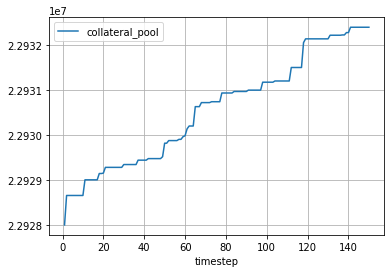

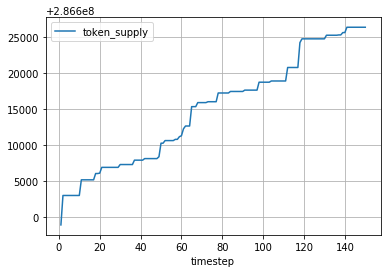

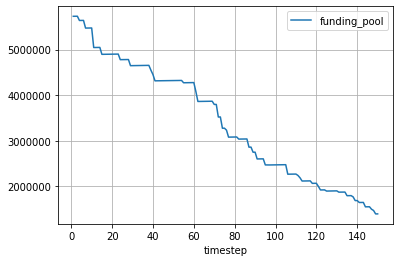

In [7]:
df_final.plot("timestep", "collateral_pool", grid=True)
df_final.plot("timestep", "token_supply", grid=True)
df_final.plot("timestep", "funding_pool", grid=True)

In [8]:
# import matplotlib.pyplot as plt
# supporters = get_edges_by_type(network, 'support')
# influencers = get_edges_by_type(network, 'influence')
# competitors = get_edges_by_type(network, 'conflict')

# nx.draw_kamada_kawai(network, nodelist = get_participants(network), edgelist=influencers)
# plt.title('Participants Social Network')

In [9]:
# For the Flask backend
result = {
    "timestep": list(df_final["timestep"]),
    "funding_pool": list(df_final["funding_pool"]),
    "token_supply": list(df_final["token_supply"]),
    "collateral": list(df_final["collateral_pool"])
}